<a href="https://colab.research.google.com/github/roncamposj/Computer-Vision-Introductory-Assignments/blob/main/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first image


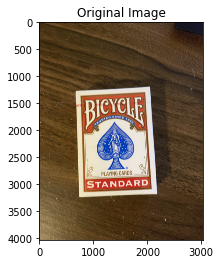

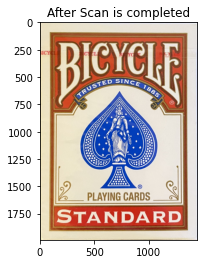

The second image


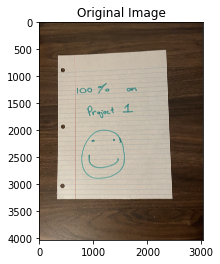

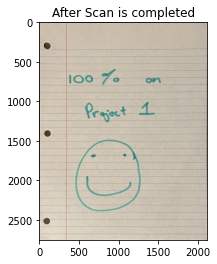

The image required to process


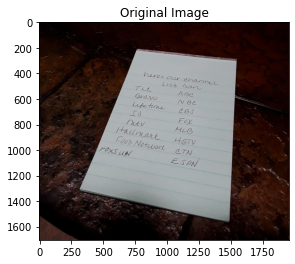

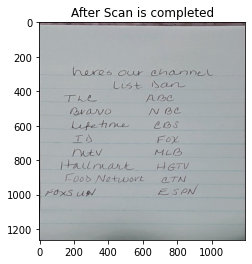

In [ ]:
import numpy as np
import cv2
import re
import imutils
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt

#function that finds the points in a rectangle
def findExactPoints(pts):
  rectangle = np.zeros((4, 2), dtype = "float32")
  pts = pts.reshape((4,2))
  
  s = pts.sum(axis = 1)
  rectangle[0] = pts[np.argmin(s)]
  rectangle[2] = pts[np.argmax(s)]

  difference = np.diff(pts, axis = 1)

  rectangle[1] = pts[np.argmin(difference)]
  rectangle[3] = pts[np.argmax(difference)]

  return rectangle

#function that contours the threshold derived from Otsu's method and approximates the shape
def findCorners(thresh):
  cntrs = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  cntrs = imutils.grab_contours(cntrs)
  cntrs = sorted(cntrs, key = cv2.contourArea, reverse = True)
  
  for c in cntrs:
  # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  
    if len(approx) == 4:
      screenCntrs = approx
      break

  return screenCntrs  

#projective homography function     
def computeH(im1_pts, im2_pts):
  n = (int)(np.size(im1_pts) / 2)
  A = np.zeros((2*n, 9))


  for i in range(0,n):
    p = im1_pts[i]
    p_prime = im2_pts[i]
    A[2*i,:] = [p[0], p[1], 1, 0, 0, 0, -1*p_prime[0]*p[0], -1*p_prime[0]*p[1],-1*p_prime[0]]
    A[2*i + 1,:] = [0, 0, 0, p[0], p[1], 1, -1*p_prime[1]*p[0], -1*p_prime[1]*p[1], -1*p_prime[1]]


  U, S, V = np.linalg.svd(A, full_matrices = True)
  L = V[-1,:] / V[-1,-1]
  H = L.reshape(3,3)

  return H    

#function that finds greatest height and width in isolated image
def findH_W(image, pts):
    rectangle = findExactPoints(pts)
    (t_l, t_r, b_r, b_l) = rectangle
 
 
    t_w = np.sqrt(((t_r[0] - t_l[0]) ** 2) + ((t_r[1] - t_l[1]) ** 2))
    b_w = np.sqrt(((b_r[0] - b_l[0]) ** 2) + ((b_r[1] - b_l[1]) ** 2))
    r_w = np.sqrt(((t_r[0] - b_r[0]) ** 2) + ((t_r[1] - b_r[1]) ** 2))
    l_w = np.sqrt(((t_l[0] - b_l[0]) ** 2) + ((t_l[1] - b_l[1]) ** 2))

    maxWidth = max(int(t_w), int(b_w))
    maxHeight = max(int(r_w), int(l_w))

    return rectangle, maxWidth, maxHeight

#function that performs the graying of image, gaussian blur, and otsu's method.  Calls auxilliaries
#above as well as cv2's warp function.  Then returns warped image and original
def imageInput(image):
  orig = image.copy()
  orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
  grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(grayImage, (5, 5), 0)
  _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_OTSU)
  contours = findCorners(thresh)

  rectangle, maxWidth, maxHeight = findH_W(image, contours.reshape(4, 2))
  dst = np.array([ [0, 0], [maxWidth - 1, 0], [maxWidth - 1, maxHeight - 1], [0, maxHeight - 1]], dtype = "float32")
  M = computeH(rectangle,dst)
  warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
  warped = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

  return orig, warped

image = cv2.imread('deck.jpg')
deck, warpedDeck = imageInput(image)
 
image2 = cv2.imread('smiley.jpg')
smiley, warpedSmiley = imageInput(image2) 

image3 = cv2.imread('givenImg.jpg')
chanList, warpedList = imageInput(image3) 


#print the three images
print("The first image")
plt.title("Original Image")
plt.imshow(deck)
plt.show()
plt.title("After Scan is completed")
plt.imshow(warpedDeck)
plt.show()

print("The second image")
plt.title("Original Image")
plt.imshow(smiley)
plt.show()
plt.title("After Scan is completed")
plt.imshow(warpedSmiley)
plt.show()

print("The image required to process")
plt.title("Original Image")
plt.imshow(chanList)
plt.show()
plt.title("After Scan is completed")
plt.imshow(warpedList)
plt.show()

My method involves the following:

1.  Take an image and pass it through a function that does the following: Converts the image color into Grayscale, blurs the gray image with a Gaussian filter, and runs Otsu's method on the blurred image.

2.  This function will take this thresholded image and pass it to a function which will find the approximate corners of the image by finding the contours, calculating their perimeter, and then approximating the shape from that.

3.  We then call a function made to find the height and width inside this perimeter.  Inside this function, we call a function created that specificially identifies four points in a square/rectangular region (as that consists of the image shapes that will be passed).  
Once this is determined, we find the magnitudes of the high width, low      width, left height, right height, and find the max values from the respective heights and widths.  This is important because they will serve as the limits that will be passed to our warping function later on.  This function returns the exact points of the corners, and the max height and width.

4.  With these max height and width values, we create a destination array and run that through our projective homography function.

5.  Now we just run our warping function and pass in as parameters the original image, the result from the homography projection, and the height and width parameters.  Finally, the image gets converted to RGB.

6.  All that is left is to display the images.  I chose to display the original with the warped image(s) right below.



I feel I could improve the clarity in the images by increasing the contrast with a bit more tinkering, or maybe using another method other than Otsu's.  Additionally, I ran into some problems with getting the picture colors to correctly display even for the originals.  I assume this could be due to a conflict between using both cv2_imshow and matplotlib to process the images, or maybe matplotlib.imshow() somehow converting images to BGR. As a work around I just converted the input image to RGB at the beginning and the warped image at the end.  I believe there is probably a better workaround to this issue though. 

All in all though, I am happy with my results. 